### Notebook for the IBM Data Science Capstone Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('SeattleCollisionData.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Basic Data Exploration

In [3]:
#check general features of the data
data.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [4]:
data.shape

(194673, 38)

In [5]:
data.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

The data attribute descriptions were reviewed in the PDF document supplied by Seattle GeoData ( https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf). Keeping in mind the ultimate goal of this project (to predict accident severity in such a way that the information could be utilized to prevent the accidents from occurring in the first place), numerous columns were omitted. 

Some columns served no real purpose for analysis, such as INCKEY, OBJECTID, COLDETKEY,etc. 

Some other columns provided information about the accident that could only be determined once the accident occurred (ex. VEHCOUNT, PERSONCOUNT, ST_COLDESC, ST_COLCODE, etc.), and/or would provide information that partially duplicated the attribute we wish to predict (INJURIES, SERIOUSINJURIES, FATALITIES, COLLISIONTYPE). 

The information that would be the most helpful in helping predict and prevent accidents was determined to be the weather, road conditions, light conditions, address type (alley, block, or intersection), whether a driver was speeding, and whether a driver wasn't paying attention to the road. Although the last two factors can only be partially controlled (since you can't control the behaviour of other drivers on the road), they could play a significant role in accident severity. 

These attributes were isolated into a new dataframe. 

In [6]:
df = data[['SEVERITYCODE', 'ADDRTYPE', 'INATTENTIONIND', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'SPEEDING', 'UNDERINFL']]

In [7]:
df.head()

,SEVERITYCODE,ADDRTYPE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,UNDERINFL
0,2,Intersection,NaN,Overcast,Wet,Daylight,NaN,N
1,1,Block,NaN,Raining,Wet,Dark - Street Lights On,NaN,0
2,1,Block,NaN,Overcast,Dry,Daylight,NaN,0
3,1,Block,NaN,Clear,Dry,Daylight,NaN,N
4,2,Intersection,NaN,Raining,Wet,Daylight,NaN,0


In [8]:
df.shape

(194673, 8)

In [9]:
#double check that data types of attributes make sense 
df.dtypes


SEVERITYCODE       int64
ADDRTYPE          object
INATTENTIONIND    object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
SPEEDING          object
UNDERINFL         object
dtype: object

### Find and address null and unknown values

Determine if columns have missing values.

In [10]:
df.loc[:, df.isnull().any()].columns

Index(['ADDRTYPE', 'INATTENTIONIND', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'SPEEDING', 'UNDERINFL'],
      dtype='object')

In [11]:
df['INATTENTIONIND'].value_counts()

Y    29805
Name: INATTENTIONIND, dtype: int64

In [12]:
df['SPEEDING'].value_counts()

Y    9333
Name: SPEEDING, dtype: int64

NaN values for INATTENTIONIND and SPEEDING are assumed to be "no", and must be filled so that they are no longer null. 


In [13]:
df['INATTENTIONIND'] = df['INATTENTIONIND'].fillna('N')
df['SPEEDING'] = df['SPEEDING'].fillna('N')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
df['UNDERINFL'].value_counts()

N    100274
0     80394
Y      5126
1      3995
Name: UNDERINFL, dtype: int64

In [15]:
# need to convert "0" to "N" and "1" to "Y"
df['UNDERINFL'] = df['UNDERINFL'].replace(['0'],'N')
df['UNDERINFL'] = df['UNDERINFL'].replace(['1'],'Y')
df['UNDERINFL'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


N    180668
Y      9121
Name: UNDERINFL, dtype: int64

In [16]:
#check for columns with missing values
df.loc[:, df.isnull().any()].columns

Index(['ADDRTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'UNDERINFL'], dtype='object')

In [17]:
df = df.dropna(subset = ['UNDERINFL'], axis = 0)

INATTENTIONIND AND SPEEDING columns no longer have missing values. 

In [18]:
df['SEVERITYCODE'].value_counts()

1    132630
2     57159
Name: SEVERITYCODE, dtype: int64

SEVERITYCODE is the target attribute. There are no unknown, abnormal, or missing values to be dealt with. 

The documentation for the dataset indicates that the values for this column have 5 potential values (0, 1, 2, 2b, and 3), however only 2 are actually present in the dataset. 

1 indicates a less severe accident that only involves property damage. 
2 indicates an accident that involves personal injury. 

2b would have indicated serious injury, and 3 would have indicated fatalities. 

In [19]:
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

Because a mean cannot be determined for these categorical values, and guessing them would likely skew the results in an undesirable way, I decided to drop 'unknown' or missing values for the weather, road conditions, light conditions, and address type columns

In [20]:
df = df.drop(df.loc[df['WEATHER']=='Unknown'].index, axis=0)
df = df.dropna(subset = ['WEATHER'], axis = 0)
df['WEATHER'].value_counts()

Clear                       111135
Raining                      33145
Overcast                     27714
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [21]:
df['ROADCOND'].value_counts()

Dry               123590
Wet                47021
Unknown             1457
Ice                 1132
Snow/Slush           910
Other                118
Standing Water       108
Sand/Mud/Dirt         66
Oil                   61
Name: ROADCOND, dtype: int64

In [22]:
df = df.drop(df.loc[df['ROADCOND']=='Unknown'].index, axis=0)
df = df.dropna(subset = ['ROADCOND'], axis = 0)
df['ROADCOND'].value_counts()

Dry               123590
Wet                47021
Ice                 1132
Snow/Slush           910
Other                118
Standing Water       108
Sand/Mud/Dirt         66
Oil                   61
Name: ROADCOND, dtype: int64

In [23]:
df['LIGHTCOND'].value_counts()

Daylight                    112836
Dark - Street Lights On      46845
Dusk                          5662
Dawn                          2424
Unknown                       2335
Dark - No Street Lights       1415
Dark - Street Lights Off      1118
Other                          201
Dark - Unknown Lighting          9
Name: LIGHTCOND, dtype: int64

In [24]:
df = df.drop(df.loc[df['LIGHTCOND']=='Unknown'].index, axis=0)
df = df.drop(df.loc[df['LIGHTCOND']=='Other'].index, axis=0)
df = df.drop(df.loc[df['LIGHTCOND']=='Dark - Unknown Lighting'].index, axis=0)
df = df.dropna(subset = ['LIGHTCOND'], axis = 0)
df['LIGHTCOND'].value_counts()

Daylight                    112836
Dark - Street Lights On      46845
Dusk                          5662
Dawn                          2424
Dark - No Street Lights       1415
Dark - Street Lights Off      1118
Name: LIGHTCOND, dtype: int64

In [25]:
df['ADDRTYPE'].value_counts()

Block           107617
Intersection     61366
Alley              595
Name: ADDRTYPE, dtype: int64

In [26]:
df = df.dropna(subset = ['ADDRTYPE'], axis = 0)

In [27]:
df.loc[:, df.isnull().any()].columns

Index([], dtype='object')

Null and unknown value have now been cleared or replaced with usable data. 

In [28]:
df.shape

(169578, 8)

### Balancing the data

In [29]:
#the data is unbalanced with regards to the target attribute:
df['SEVERITYCODE'].value_counts()

1    113924
2     55654
Name: SEVERITYCODE, dtype: int64

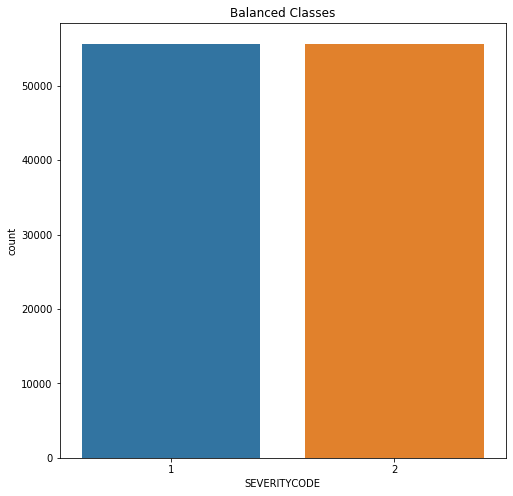

In [30]:
#The data will be adjusted using undersampling. 55,654 of the SEVERITYCODE = 1 group need to be randomly selected. 

# Shuffle the data
shuffled_df = df.sample(frac=1,random_state=4)

# Put all the injury(2) observations in a separate dataset.
injury_df = shuffled_df.loc[shuffled_df['SEVERITYCODE'] == 2]

#Randomly select 55654 observtations from the non-injury accidents
non_injury_df = shuffled_df.loc[shuffled_df['SEVERITYCODE'] == 1].sample(n=55654,random_state=42)

# Concatenate both dataframes again
df2 = pd.concat([injury_df, non_injury_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('SEVERITYCODE', data=df2)
plt.title('Balanced Classes')
plt.show()

In [31]:

df2['SEVERITYCODE'].value_counts()

2    55654
1    55654
Name: SEVERITYCODE, dtype: int64

### Exploratory Visualization and Analysis

The dataset still contains an adequate number of data points for analysis, hooray!

Time to get some quick visualizations of the data. 

In [32]:
df2.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True)


LIGHTCOND                 SEVERITYCODE
Dark - No Street Lights   1               0.616114
                          2               0.383886
Dark - Street Lights Off  1               0.569038
                          2               0.430962
Dark - Street Lights On   1               0.526361
                          2               0.473639
Dawn                      2               0.516603
                          1               0.483397
Daylight                  2               0.511860
                          1               0.488140
Dusk                      2               0.509106
                          1               0.490894
Name: SEVERITYCODE, dtype: float64

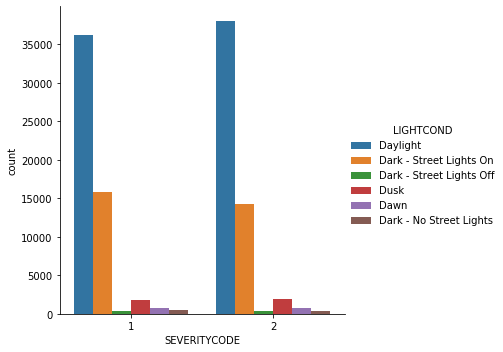

In [33]:
sns.catplot(data=df2, hue='LIGHTCOND', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents appear to be slightly more likely during daylight, and at dawn and dusk

In [34]:
df2.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True)

WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.535714
                          2               0.464286
Clear                     1               0.500401
                          2               0.499599
Fog/Smog/Smoke            2               0.505556
                          1               0.494444
Other                     1               0.519231
                          2               0.480769
Overcast                  1               0.509291
                          2               0.490709
Partly Cloudy             2               1.000000
Raining                   2               0.512900
                          1               0.487100
Severe Crosswind          1               0.500000
                          2               0.500000
Sleet/Hail/Freezing Rain  1               0.602941
                          2               0.397059
Snowing                   1               0.663223
                          2               0

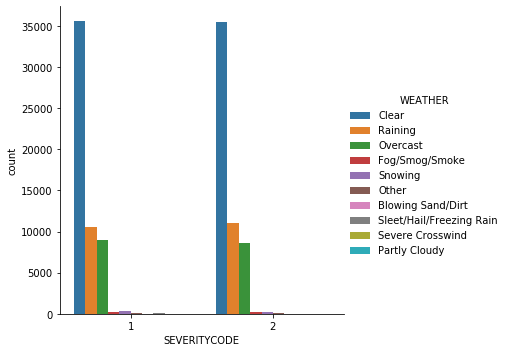

In [35]:
sns.catplot(data=df2, hue='WEATHER', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents appear to be more like in Fog/Smog/Smoke, Partly Cloudy, and Rain conditions

In [36]:
df2.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True)

ROADCOND        SEVERITYCODE
Dry             1               0.501303
                2               0.498697
Ice             1               0.607988
                2               0.392012
Oil             2               0.615385
                1               0.384615
Other           2               0.583333
                1               0.416667
Sand/Mud/Dirt   2               0.512195
                1               0.487805
Snow/Slush      1               0.674419
                2               0.325581
Standing Water  1               0.640000
                2               0.360000
Wet             2               0.508474
                1               0.491526
Name: SEVERITYCODE, dtype: float64

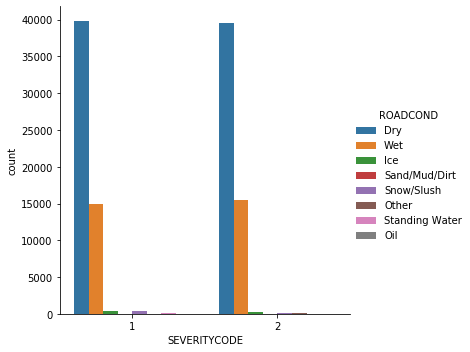

In [37]:
sns.catplot(data=df2, hue='ROADCOND', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents appear to be more likely in oil, other, sand/mud/dirt, and wet road conditions

In [38]:
df2.groupby(['INATTENTIONIND'])['SEVERITYCODE'].value_counts(normalize=True)

INATTENTIONIND  SEVERITYCODE
N               1               0.506576
                2               0.493424
Y               2               0.531479
                1               0.468521
Name: SEVERITYCODE, dtype: float64

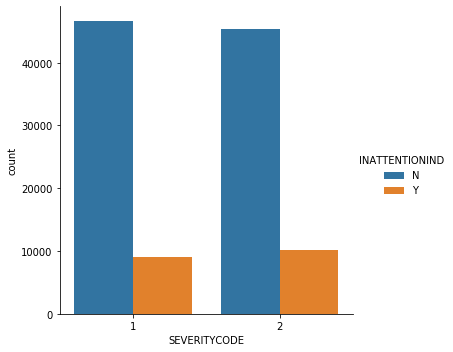

In [39]:
sns.catplot(data=df2, hue='INATTENTIONIND', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents appear to be more likely in situations where a driver is inattentive

In [40]:
df2.groupby(['SPEEDING'])['SEVERITYCODE'].value_counts(normalize=True)

SPEEDING  SEVERITYCODE
N         1               0.503604
          2               0.496396
Y         2               0.561586
          1               0.438414
Name: SEVERITYCODE, dtype: float64

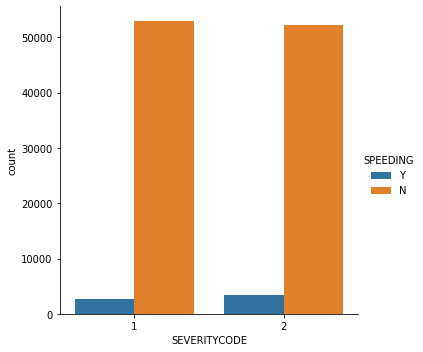

In [41]:
sns.catplot(data=df2, hue='SPEEDING', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents appear to be more likely when a driver is speeding

In [42]:
df2.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True)

ADDRTYPE      SEVERITYCODE
Alley         1               0.765244
              2               0.234756
Block         1               0.572375
              2               0.427625
Intersection  2               0.613045
              1               0.386955
Name: SEVERITYCODE, dtype: float64

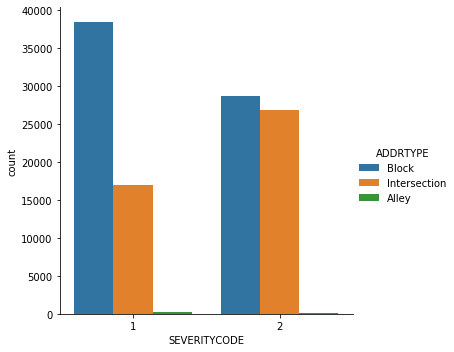

In [43]:
sns.catplot(data=df2, hue='ADDRTYPE', kind='count', x='SEVERITYCODE', order=[1,2])


#### Injury accidents are more likely at intersections, and much less likely in alleys

In [44]:
df2.groupby(['UNDERINFL'])['SEVERITYCODE'].value_counts(normalize=True)

UNDERINFL  SEVERITYCODE
N          1               0.503966
           2               0.496034
Y          2               0.567563
           1               0.432437
Name: SEVERITYCODE, dtype: float64

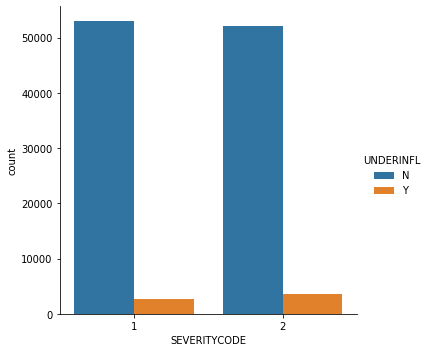

In [45]:
sns.catplot(data=df2, hue='UNDERINFL', kind='count', x='SEVERITYCODE', order=[1,2])

#### Injury accident appear to be more likely when a driver is under the influence of drugs or alcohol. 

### Convert Categorial Attributes to Numerical Values

In [46]:
df2.head()

,SEVERITYCODE,ADDRTYPE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,UNDERINFL
87130,2,Block,N,Clear,Dry,Daylight,Y,N
184305,2,Intersection,N,Clear,Dry,Daylight,N,Y
75968,2,Block,N,Clear,Dry,Daylight,N,N
161441,2,Intersection,N,Raining,Wet,Dark - Street Lights On,N,N
74650,2,Intersection,N,Raining,Wet,Dark - Street Lights On,N,N


In [47]:
#convert binary categorical attributes to numerical values: Inattention, Speeding, and Under Influence
df2['INATTENTIONIND'].replace(to_replace=['N','Y'], value=[0,1],inplace=True)
df2['SPEEDING'].replace(to_replace=['N','Y'], value=[0,1],inplace=True)
df2['UNDERINFL'].replace(to_replace=['N','Y'], value=[0,1],inplace=True)
df2.head()

,SEVERITYCODE,ADDRTYPE,INATTENTIONIND,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,UNDERINFL
87130,2,Block,0,Clear,Dry,Daylight,1,0
184305,2,Intersection,0,Clear,Dry,Daylight,0,1
75968,2,Block,0,Clear,Dry,Daylight,0,0
161441,2,Intersection,0,Raining,Wet,Dark - Street Lights On,0,0
74650,2,Intersection,0,Raining,Wet,Dark - Street Lights On,0,0


### One Hot Encoding for Categorical Variables with Multiple Classes

In [48]:
#For use with a machine learning model, categorical variables need to be converted to binary variables. This needs to be 
#done for Address Type, Weather, Road Conditions, and Light Conditions
Feature = df2[['INATTENTIONIND', 'SPEEDING', 'UNDERINFL']]
Feature = pd.concat([Feature,pd.get_dummies(df2['ADDRTYPE'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df2['WEATHER'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df2['ROADCOND'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(df2['LIGHTCOND'])], axis=1)
Feature.head(15)

,INATTENTIONIND,SPEEDING,UNDERINFL,Alley,Block,Intersection,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,...,Sand/Mud/Dirt,Snow/Slush,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dawn,Daylight,Dusk
87130,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
184305,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
75968,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
161441,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
74650,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
39120,0,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
38217,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
66248,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
76409,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
170750,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
#verify columns are what is desired
Feature.columns

Index(['INATTENTIONIND', 'SPEEDING', 'UNDERINFL', 'Alley', 'Block',
       'Intersection', 'Blowing Sand/Dirt', 'Clear', 'Fog/Smog/Smoke', 'Other',
       'Overcast', 'Partly Cloudy', 'Raining', 'Severe Crosswind',
       'Sleet/Hail/Freezing Rain', 'Snowing', 'Dry', 'Ice', 'Oil', 'Other',
       'Sand/Mud/Dirt', 'Snow/Slush', 'Standing Water', 'Wet',
       'Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk'],
      dtype='object')

### Feature Selection

In [50]:
X = Feature
X[0:5]

,INATTENTIONIND,SPEEDING,UNDERINFL,Alley,Block,Intersection,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Other,...,Sand/Mud/Dirt,Snow/Slush,Standing Water,Wet,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dawn,Daylight,Dusk
87130,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
184305,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
75968,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
161441,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
74650,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [51]:
y = df2['SEVERITYCODE'].values
y[0:5]

array([2, 2, 2, 2, 2], dtype=int64)

### Normalize Data

In [52]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.45706709,  4.13365429, -0.24229097, -0.0543644 ,  0.81028776,
        -0.80530675, -0.01586246,  0.75199158, -0.05696282, -0.0374631 ,
        -0.43255989, -0.00519162, -0.48998982, -0.01121575, -0.0247243 ,
        -0.06608544,  0.63355145, -0.07816871, -0.0187217 , -0.02544155,
        -0.01919591, -0.06532691, -0.02596652, -0.61442909, -0.08740994,
        -0.08051924, -0.60909013, -0.11945641,  0.70536844, -0.18630886],
       [-0.45706709, -0.2419167 ,  4.12726891, -0.0543644 , -1.23412946,
         1.24176285, -0.01586246,  0.75199158, -0.05696282, -0.0374631 ,
        -0.43255989, -0.00519162, -0.48998982, -0.01121575, -0.0247243 ,
        -0.06608544,  0.63355145, -0.07816871, -0.0187217 , -0.02544155,
        -0.01919591, -0.06532691, -0.02596652, -0.61442909, -0.08740994,
        -0.08051924, -0.60909013, -0.11945641,  0.70536844, -0.18630886],
       [-0.45706709, -0.2419167 , -0.24229097, -0.0543644 ,  0.81028776,
        -0.80530675, -0.01586246,  0.75199158, -0

### Create the train/test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (89046, 30) (89046,)
Test set: (22262, 30) (22262,)


### K Nearest Neighbours Model

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [55]:
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [56]:
#create prediction
yhat = neigh.predict(X_test)
yhat[0:5]

array([2, 1, 1, 2, 2], dtype=int64)

In [57]:
#assess accuracy of the model
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5033578150618782
Test set Accuracy:  0.49299254334740816


In [58]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.53319558, 0.5176534 , 0.49164496, 0.49299254, 0.50067379,
       0.49775402, 0.53589076, 0.53076992, 0.53656455])

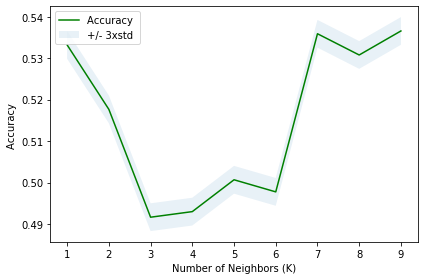

In [59]:
#Plot model accuracy for different k values
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [60]:
#determine the best accuracy
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.5365645494564729 with k= 9


In [61]:
#retrain the model with k = 9
k = 9
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [62]:
#create prediction with new model
yhat = neigh.predict(X_test)
yhat[0:5]

array([2, 1, 2, 2, 2], dtype=int64)

In [63]:
#Check accuracy of the new model
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.5424948902814276
Test set Accuracy:  0.5365645494564729


### Decision Tree Model

In [64]:
#Import Scikit-learn decision tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [65]:
#Create an instance of the DecisionTreeClassifier
InjuryTree = DecisionTreeClassifier(criterion="entropy", max_depth = 20)
InjuryTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [66]:
#Fit the data
InjuryTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [67]:
#Make a prediction
predTree = InjuryTree.predict(X_test)
print (predTree [0:5])
print (y_test [0:5])

[1 1 2 1 1]
[2 2 2 2 2]


In [68]:
#Check accuracy of the model
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))

DecisionTrees's Accuracy:  0.5959033330338693


### Support Vector Machine Model

In [69]:
from sklearn import svm

In [70]:
#fit the model
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [71]:
#create a prediction
yhat_svm = clf.predict(X_test)
yhat_svm [0:5]

array([1, 1, 2, 1, 1], dtype=int64)

In [72]:
#Check accuracy of the model
print("SVM's Accuracy: ", metrics.accuracy_score(y_test, yhat_svm))

SVM's Accuracy:  0.5969364836941874


### Logistic Regression Model

In [73]:
from sklearn.linear_model import LogisticRegression

In [74]:
#fit the model
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
#create prediction
yhat_LR = LR.predict(X_test)
yhat_LR[0:5]

array([1, 1, 2, 1, 1], dtype=int64)

In [76]:
#predict probabilities
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[0.58662205, 0.41337795],
       [0.62561619, 0.37438381],
       [0.38966538, 0.61033462],
       [0.58662205, 0.41337795],
       [0.58662205, 0.41337795]])

In [77]:
#Check accuracy of the model
print("Logistic Regression's Accuracy: ", metrics.accuracy_score(y_test, yhat_LR))

Logistic Regression's Accuracy:  0.5955439762824544


### Model Evaluation

In [78]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [79]:
#KNN Metrics
KNN_yhat = neigh.predict(X)

In [80]:
KNN_Jaccard = jaccard_similarity_score(y, KNN_yhat)
print(KNN_Jaccard)

0.5413088008049736


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [81]:
KNN_f1 = f1_score(y, KNN_yhat, average = 'weighted')
print(KNN_f1)

0.5289378752586781


In [82]:
#Decision Tree Metrics
DT_yhat = InjuryTree.predict(X)

In [83]:
DT_Jaccard = jaccard_similarity_score(y, DT_yhat)
print(DT_Jaccard)

0.5983577101376361


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [84]:
DT_f1 = f1_score(y, DT_yhat, average = 'weighted')
print(DT_f1)

0.5983250295815876


In [85]:
#SVM Metrics
SVM_yhat = clf.predict(X)

In [86]:
SVM_Jaccard = jaccard_similarity_score(y, SVM_yhat)
print(SVM_Jaccard)

0.5970460344269953


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [87]:
SVM_f1 = f1_score(y, SVM_yhat, average = 'weighted')
print(SVM_f1)

0.5968810217696339


In [88]:
#Logistic Regression metrics
LR_yhat = LR.predict(X)
LR_yhat_prob = LR.predict_proba(X)

In [89]:
LR_Jaccard = jaccard_similarity_score(y, LR_yhat)
print(LR_Jaccard)

0.5933535774607396


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [90]:
LR_f1 = f1_score(y, LR_yhat, average = 'weighted')
print(LR_f1)

0.5914322479597585


In [91]:
LR_logloss = log_loss(y, LR_yhat_prob)
print(LR_logloss)

0.6712431759762768


### Metrics Report

In [92]:
metrics = {'Algorithm': ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression'],
           'Jaccard': [KNN_Jaccard, DT_Jaccard, SVM_Jaccard, LR_Jaccard], 
           'F1-score': [KNN_f1, DT_f1, SVM_f1, LR_f1],
           'Log Loss': ['NA', 'NA', 'NA', LR_logloss]
          }

metrics_df = pd.DataFrame(metrics, columns = ['Algorithm', 'Jaccard', 'F1-score', 'Log Loss'])

metrics_df

,Algorithm,Jaccard,F1-score,Log Loss
0,KNN,0.541309,0.528938,NA
1,Decision Tree,0.598358,0.598325,NA
2,SVM,0.597046,0.596881,NA
3,Logistic Regression,0.593354,0.591432,0.671243
